# Maximum Likelihood Estimation for Normal Distribution

## 1. Maximum Likelihood

### Historical (De)tour

Who would rise to argue in favor of a method of minimum likelihood, or even mediocre likelihood? And yet the mathematical history of MLE shows this “simple idea” is really anything but simple. 

**Lagrange**, **Bernoulli**, **Euler**, **Laplace** and **Gauss** are only some of those who explored the topic, not always in ways we would sanction today.

For all its turbulent past, maximum likelihood has survived
numerous assaults and remains a beautiful, if increasingly complicated theory.

[Source:Stigler](https://arxiv.org/pdf/0804.2996.pdf)

### Mathematical Overview

**Fisher** first presented the idea in [1912](http://tankona.free.fr/fisher1912.pdf), that too in surprisingly few lines.

<center>

<img src="https://user-images.githubusercontent.com/6872080/106067506-ccc52880-60cc-11eb-97e8-b6579b5dbcad.png" width="50%">

</center>

### Deeper Dive
Let's break it down

So $f$ or $f(x)$ is the function, whose parameters ($\theta$) we want to estimate.

Probability of observing a small change in our features $(x)$ is given by
$$ p = f(x)*dx $$

Now since we have $n$ observations in our dataset , each being $i.i.d$ (independently and identically drawn from the same distribution), therefore probability of observing the changes in the entire dataset will be a product of individual observations

$$ P^` = \prod_{i=1}^{n} f(x)*dx $$

Now taking log on both sides

$$ log(P^`) = \sum_{i=1}^{n} log(f(x)) + log(dx) $$

Now since $dx$ doesn't depend on the parameters and the function, it's simply a constant and won't change as we change the parameters of $f(x)$

Therefore we get

$$ log(P^`) \propto \sum_{i=1}^{n} log(f(x)) $$

*Fisher* calls the summation term on the right $log(P)$.

Now if we find $\theta $ for $ f(x) $ such that $\sum_{i=1}^{n} log(f(x)) $ is maximized, then in turn $log(P^`)$ will be maximized which is essentially the *likelihood* of observing the dataset we have.

Therefore the pursuit is to find parameters for the function that maximize the likelihood of observing the dataset.


Let's get a better understanding using visualizations.

Lets generate some 1-d data from a known normal distribution with mean 0 and standard deviation of 10.

We also generate data from two other distributions with different means and standard deviations to make our point.


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd

In [29]:
x = np.random.normal(0,10 , 1000)

pa = np.random.normal(-5,7 , 1000)
pb = np.random.normal(15,2 , 1000)

pldf = pd.DataFrame({"x" : x , "pa" : pa , "pb" : pb , "y" : np.ones_like(x)*0.01})

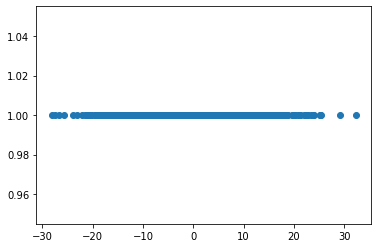

In [30]:
plt.scatter(x , np.ones_like(x))

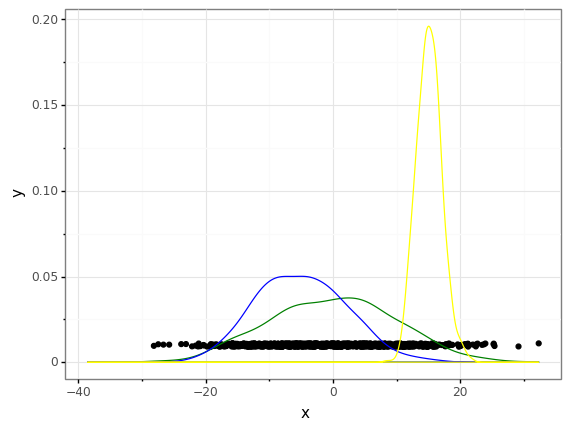

<ggplot: (8759665947228)>

In [31]:
(
    ggplot(pldf )
    + geom_jitter(aes(x="x" , y="y") , height=0.001)
    + geom_density(aes(x="x") , color="green")
    + geom_density(aes(x="pa") , color="blue")
    + geom_density(aes(x="pb") , color="yellow")
    + theme_bw()
)

NOW suppose you were asked that having seen the figure above, which distribution ,`green`, `blue` or `yellow` do you think generated the data points (black dots) ? 

Since mean of `yellow` seems too far to the right of the mean of the dots, it's `unlikely` that it would have generated our points. With similar reasoning we can reject `blue` as well.

`Green` seems to be centered over the data points and coveres almost all of them symmetrically.

Therefore `best` bet would be the `green` one.

This is exactly the intuition of `MLE`! 
Instead of visually, mathematically we want to find the best parameters for our distribution that maximize the likelihood of seeing the data that we have at hand.

### Iteractive Intuition

Okay we can do even better, let's build our intuition using interactive visualization.

Below try finding the values for `mean` and `std` for which the log-likelihood (LL) is maximized. Try playing with one parameter at a time, fixing it's value to one where LL is maximized

In [32]:
from scipy.stats import norm

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
def log_likelihood(mean , std):
  px = norm(mean,std)
  pldf = pd.DataFrame({"x" : x, "sx" : np.random.normal(mean,std,1000) , "y" : np.ones_like(x)*0.001})
  ll= np.sum(np.log(np.array([px.pdf(xi) for xi in x])))
  return (
    ggplot(pldf )
    + geom_jitter(aes(x="x" , y="y") , height=0.001)
    + geom_density(aes(x="sx") , color="green")
    + theme_bw()
    + ggtitle(f"Log-Likelihood : {ll}")
    + scale_x_continuous(limits=(np.min(x) - 50 , np.max(x) + 50))
  )

interact(log_likelihood 
         , mean=widgets.IntSlider(min=-5, max=10, step=1, value=5) 
         , std=widgets.IntSlider(min=1, max=10, step=1, value=5))

interactive(children=(IntSlider(value=5, description='mean', max=10, min=-5), IntSlider(value=5, description='…

<function __main__.log_likelihood>

Important thing to note here is that LL gets maximized when the mean is set to 0 and std is set to 10, which are exactly the parameters of the normal distribution that generated the data point!

Okay but we cheated here, sort of. We visually tried different values for the parameters ($\theta$) from a very small set. But in practice the parameters are real valued and therefore we need a mathematical / algorithmic way to find exactly what these parameters are.

## Finding the parameters

So... We want to maximize log-likelihood. Now one thing that we have learnt is that when maximizing a function , we take it's derivative and set it to zero.

$$ f(x) = LL^`(x) = 0 $$

which is really 
$$ \frac{ \partial f}{\partial \theta}  = 0  $$



Now let's try to implement this for our earlier problem of finding $\mu$ and $\sigma$ of the normal distribution from which we have assumed that the data comes.

$$ X \sim \mathcal{N}(\mu  ,\sigma^2)$$


Which is further defined by

$$ \mathcal{N} = \frac{1}{2\pi\sigma^2} e^-\frac{(x-\mu)^2}{\sigma^2} $$

Now the Log-Liklihood of obversing $i.i.d$ data from this distribution will be

$$ \sum_i{g(x_i)} $$ 

where $$ g(x_i) = log(\mathcal{F_x(x ; \mu , \sigma^2)}) $$


### Theoretical Proof

Now using the insight from above we have to find derivative of the function with respect to both parameters , $\mu$ and $\sigma$

1. For $\mu$ it is a bit straightforward

Let $$ \phi_i = \frac{(x_i-\mu)}{\sigma}  $$
then
$$ LL = \sum_i log( \frac{1}{\sqrt{2\pi\sigma^2}}e^-\frac{\phi_i^2}{2}) $$

$$ LL = \sum_i log( 1) - log({\sqrt{2\pi\sigma^2}}) + log(e^-\frac{\phi_i^2}{2}) $$

$$ LL = \sum_i - log({\sqrt{2\pi\sigma^2}}) + -\frac{\phi_i^2}{2} $$


$$ \frac{\partial{LL}}{\partial{\phi}} = \sum_i -2*\frac{\phi_i}{2} $$
setting it to 0, we get

$$ - \sum_i \phi_i = 0 $$ 

$$ - \sum_i \frac{(x_i - \mu)}{\sigma} = 0 $$ 
$$ - \sum_i (x_i - \mu) = 0 $$ 
$$ - \sum_i(x_i) +n\mu = 0 $$ where n is the number of observations in the dataset

$$ \mu = \frac{\sum_i(x_i)}{n} $$

WAIT WHAT! that's just the sample mean!!
SO MLE estimate of the mean of the distribution is just the sample mean!

2. For $\sigma$

$$ LL = \sum_i log( \frac{1}{\sqrt{2\pi\sigma^2}}e^-\frac{\phi_i^2}{2}) $$

$$ LL = \sum_i log( 1) - log({\sqrt{2\pi\sigma^2}}) + log(e^-\frac{\phi_i^2}{2}) $$

$$ LL = \sum_i - log({\sqrt{2\pi\sigma^2}}) + -\frac{\phi_i^2}{2} $$

$$ LL = \sum_i - log(\sqrt{2\pi}) -log(\sigma) + -\frac{\phi_i^2}{2} $$

$$ \frac{\partial{LL}}{\partial{\sigma}} = \sum_i -\frac{1}{\sigma} + -2*\frac{\phi_i}{2} \frac{\partial{\phi}}{\partial{\sigma}}$$

$$ \frac{\partial{\phi}}{\partial{\sigma}} = -\frac{(x-u)}{\sigma^2}$$

Therefore 

$$ \frac{\partial{LL}}{\partial{\sigma}} = \sum_i -\frac{1}{\sigma} + \frac{(x-u)}{\sigma} \frac{(x-u)}{\sigma^2}$$

Now setting the equation to 0

$$ \sum_i -\frac{1}{\sigma} + \frac{(x-u)}{\sigma} \frac{(x-u)}{\sigma^2} = 0$$

$$ \sum_i -\frac{1}{\sigma} + \frac{(x-u)}{\sigma \sigma^2}^2 = 0$$

$$ \sum_i -\frac{1}{\sigma} ( 1 + \frac{(x-u)}{\sigma^2}^2)= 0$$

$$ \sum_i ( -1 + \frac{(x-u)}{\sigma^2}^2)= 0$$

$$ \sum_i ( -1) + \sum_i \frac{(x-u)}{\sigma^2}^2= 0$$

$$ -n + \sum_i \frac{1}{\sigma^2} (x-u)^2= 0$$


$$ -n + \frac{1}{\sigma^2} \sum_i (x-u)^2= 0$$

$$ \sum_i (x-u)^2= n\sigma^2$$

$$  \sigma^2 = \frac{1}{n}\sum_i (x-u)^2$$

WAIT WHAT AGAIN! that's just the sample variance!!
SO MLE estimate of the variance of the distribution is just the sample variance!

Now we know how to estimate the mean and standard deviation directly from the data


In [33]:
np.mean(x)

0.02370665701385377

In [34]:
np.std(x)

9.79004622542148

Okay so our estimates turn out to be

$\mu = 0.024 $
$\sigma = 9.8 $

both are pretty close to what we know are the true values of 0 and 10!